In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from gpaw import GPAW
from ase.io import read
from abtem import *

# DFT potentials with GPAW

The independent atom model neglects any effect due to bonding and charge transfer. However, since the nucleus and core electrons constitute most of the charge in an atom, this is often a good approximation. Nonetheless, the difference between the indepedent atom model and a model including the effects of bonding is measurable, at least in certain systems. This difference is obviously important, since it contains all the chemistry of the system.

Here we go beyond the independent atom model using density functional.

## DFT calculation

The unit cell for the DFT calculation does not have to be orthogonal, however, the potential has to be made orthogonal before the multislice simulation. Only unit cell's that can be thought of an extruded parallelogram are allowed. If the `standardize_cell` raises an error abTEM is unable to use the DFT calculation.

We will use the minimal hexagonal cell for our graphene DFT calculation.

In [6]:
atoms = read('graphene_hexagonal.cif')

In [7]:
gpaw = GPAW(h=.1, txt=None, kpts=(4,4,4))
atoms.set_calculator(gpaw)
atoms.get_potential_energy()

-20.224803629283965

DFT calculations can be extremely computationally intensive

In [8]:
gpaw.write('graphene.gpw')

In [9]:
gpaw = GPAW('graphene.gpw', txt=None)

In [10]:
dft_potential = GPAWPotential(gpaw, sampling=.02)


In [11]:
dft_potential = dft_potential.build()

dft_potential = dft_potential.tile((3,2))

## Comparing DFT to IAM

In [13]:
from abtem.structures import orthogonalize_cell
atoms = orthogonalize_cell(gpaw.atoms) * (3,2,1)

iam_potential = Potential(atoms, gpts=dft_potential.gpts, cutoff_tolerance=1e-4, device='cpu').build()

In [14]:
projected_iam = iam_potential.array.sum(0)
projected_iam -= projected_iam.min()

projected_dft = dft_potential.array.sum(0)
projected_dft -= projected_dft.min()

absolute_difference = projected_iam - projected_dft

valid = np.abs(projected_iam) > 1
relative_difference = np.zeros_like(projected_iam)
relative_difference[:] = np.nan
relative_difference[valid] = (projected_iam[valid] - projected_dft[valid]) / projected_iam[valid]

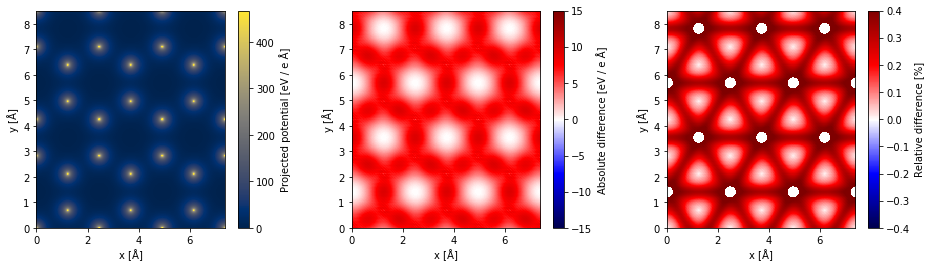

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

extent = [0, dft_potential.extent[0], 0, dft_potential.extent[1]]

im1 = ax1.imshow(projected_dft.T, cmap='cividis', extent=extent)
im2 = ax2.imshow(absolute_difference.T, vmin=-15, vmax=15, cmap='seismic', extent=extent)
im3 = ax3.imshow(relative_difference.T, vmin=-.4, vmax=.4, cmap='seismic', extent=extent)

labels = ('Projected potential [eV / e Å]', 'Absolute difference [eV / e Å]', 'Relative difference [%]')

for ax, im, label in zip((ax1, ax2, ax3), (im1, im2, im3), labels):
    ax.set_xlabel('x [Å]')
    ax.set_ylabel('y [Å]')
    
    fig.colorbar(im, ax=ax, label=label)